### Overview
Metrics for evaluating the final answer: Price Range + Reason
- MAPE + Visualization
- Reasoning score: Ask an LLM to give score on the reason

Metrics for evaluating the contexts: Retrieved products from databases or the internet
- BLEU and ROUGE score: both scores are based word match
- Context relevance: Ask an LLM to give a score on how relevant the retrieved products are


In [22]:
import evaluate
import pickle
import os
import matplotlib.pyplot as plt
import numpy as np

Each function takes an argument called ```dataset```, which is a dictionary with the form
```
{
    "test_descriptions": <list of descriptions of original products>
    "test_prices": <list of prices of each of the original products>
    "contexts": <List of List: Each inner list is the list of retrieved products for a particular original products>
    "prices_ranges": <List of List: Each inner list is price range predicted>
    "agent_responses": <List of Dicts: Each dictionary has 3 keys: input (optional), output (optional), intermediate_steps (necessary). This is based on the format of Langchain agents>
}
```
Note that if we are not using agent, the ```agent_responses``` key can be excluded

For example,
```
dataset = {
    "test_descriptions": ["shirt", "shoes"]
    "test_prices": [20, 100]
    "contexts": [["shirt1", "shirt2"], ["shoes1", "shoes2"]]
    "price_ranges": [[15, 25], [90, 105]]
    "agent_responses":
    [
        {
            "input": "What is a reasonable price range for shirt?"
            "output": "json{min, max, reason...}"
            "intermediate_steps": [AgentAction(...), AgentAction(...)]
        },
        
        {
            ...
        }
    ]
}
```

In [23]:
rag_mixtral_dataset = pickle.load(open("rag_eval/rag_mixtral_dataset.pkl", "rb"))
agent_mixtral_dataset = pickle.load(open("rag_eval/agent_mixtral_dataset.pkl", "rb"))

{
    "test_descriptions": agent_mixtral_dataset["test_descriptions"][:1],
    "test_prices": agent_mixtral_dataset["test_prices"][:1],
    "contexts": agent_mixtral_dataset["contexts"][:1],
    "price_ranges": agent_mixtral_dataset["price_ranges"][:1],
    "agent_responses": agent_mixtral_dataset["agent_responses"][:1],
}

{'test_descriptions': array(['Anti-Theft Courier Saddle Crossbody, Stone, One Size'],
       dtype=object),
 'test_prices': array([41.8]),
 'contexts': [['Anti-Theft Heritage Crossbody Bag',
   'Anti-Theft Courier Mini Crossbody, Stone Gray, One Size',
   'Anti-Theft Active Medium Crossbody, Charcoal, One Size',
   'Anti-Theft Courier Tour Bag, Stone Gray, 11.5 x 11 x 3',
   'Anti-theft Heritage Cross Body Bag Cross Body Bag, Sage, 10.5 x 7 x 2']],
 'price_ranges': [[33.4, 55.94]],
 'agent_responses': [{'input': 'what is a reasonable and accurate price range of product: Anti-Theft Courier Saddle Crossbody, Stone, One Size ',
   'output': '```json\n{\n\t"min_price": 33.4,\n\t"max_price": 55.94,\n\t"reason": "Based on the prices of similar products found in the text database, the reasonable minimum price for the \'Anti-Theft Courier Saddle Crossbody, Stone, One Size\' is $33.4 and the reasonable maximum price is $55.94. These prices were determined by comparing the prices of similar prod

In [24]:
def plot_percentage_error(dataset, plot_name="Percentage Error for each product"):
    predicted_prices = dataset["price_ranges"]
    test_prices = dataset["test_prices"]

    num_products = len(test_prices)

    percentage_errors_lst = []
    # Iterate through each product
    for i in range(num_products):
        percentage_errors = [
            (predicted_price - test_prices[i]) / test_prices[i] * 100
            for predicted_price in predicted_prices[i]
        ]
        percentage_errors_lst += percentage_errors
        # Use the product index as the x-value for all predictions of this product
        x_values = [i for _ in predicted_prices[i]]

        # Plot percentage errors for this product
        plt.scatter(x_values, percentage_errors, color="red")  # Plotting errors in blue

    # Calculate the mean absolute percentage error
    mape = np.mean(np.abs(percentage_errors_lst))

    set_lim = True
    if set_lim:
        plt.ylim(-200, 200)
        plt.text(
            0,
            -300,
            "Note: ylim is set to (-200, 200) but some errors may be outside this range",
            fontsize=12,
        )

    plt.xlabel("Product Index")
    plt.ylabel("Percentage Error (%)")
    plt.title(plot_name)
    plt.axhline(0, color="grey")
    plt.axhline(25, color="green", linestyle="--")
    plt.axhline(-25, color="green", linestyle="--")

    plt.text(
        0, -250, "Mean Absolute Percentage Error: {:.2f}%".format(mape), fontsize=12
    )

    plt.gcf().set_size_inches(20, 7)

    # plt.savefig('rag_eval/' + plot_name + '.png')

    plt.show()

    return mape / 100

### Mean Absolute Percentage Error (MAPE)

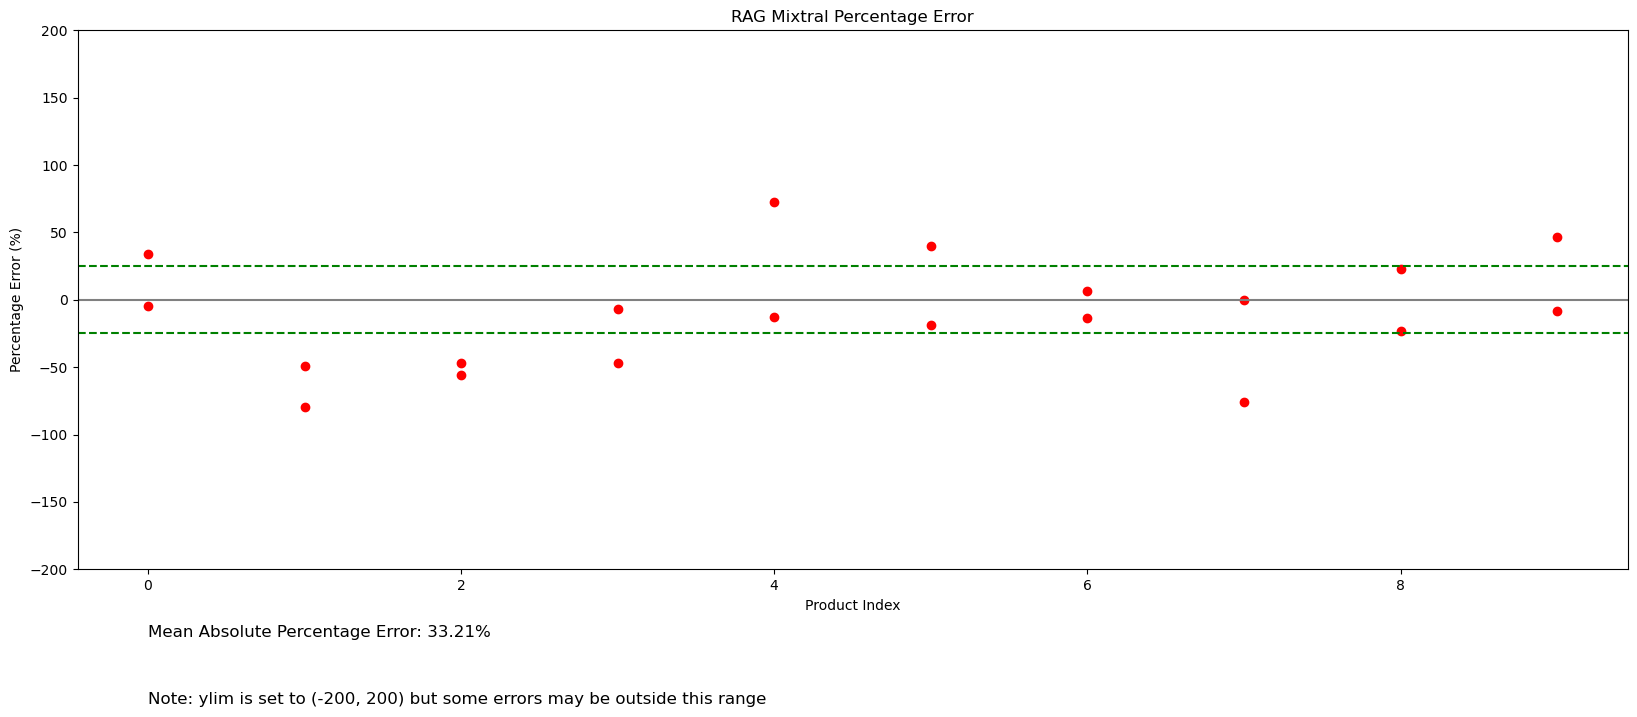

RAG Mixtral Mean Absolute Percentage Error:  0.33206861941001425


In [25]:
rag_mixtral_mape = plot_percentage_error(
    rag_mixtral_dataset, "RAG Mixtral Percentage Error"
)
print("RAG Mixtral Mean Absolute Percentage Error: ", rag_mixtral_mape)

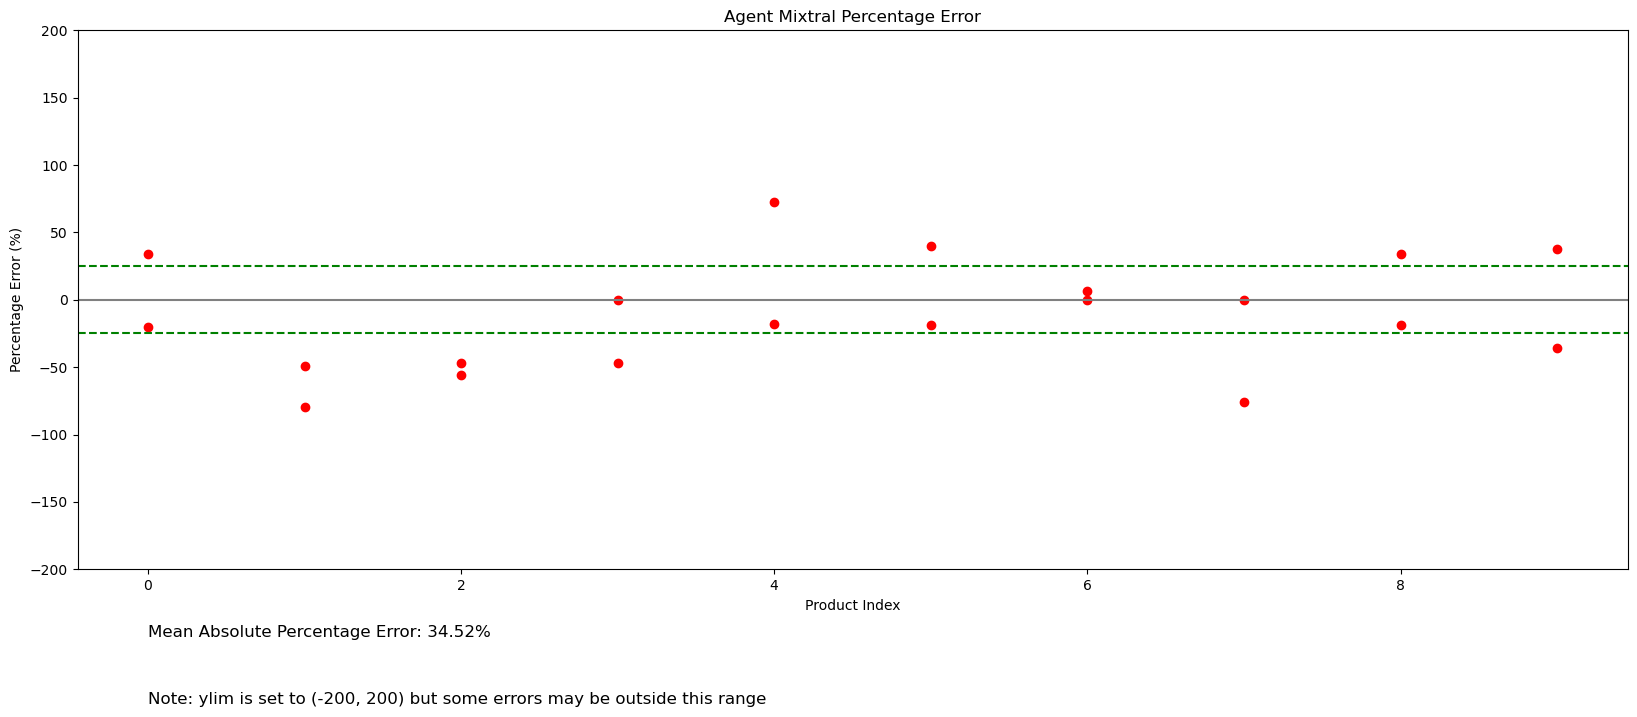

Agent Mixtral Mean Absolute Percentage Error:  0.3452354642088752


In [26]:
agent_mixtral_mape = plot_percentage_error(
    agent_mixtral_dataset, "Agent Mixtral Percentage Error"
)
print("Agent Mixtral Mean Absolute Percentage Error: ", agent_mixtral_mape)

### Reasoning Score

Copied and modified from the code of a library called Trulens: https://github.com/truera/trulens. Trulens is a library for evaluating an LLM using the LLM itself.

Prompt: https://github.com/truera/trulens/blob/main/trulens_eval/trulens_eval/feedback/v2/feedback.py

Parsing score and supporting evidence: https://github.com/truera/trulens/blob/main/trulens_eval/trulens_eval/feedback/provider/base.py

Parsing 0-10 integer: https://github.com/truera/trulens/blob/main/trulens_eval/trulens_eval/utils/generated.py

In [27]:
from langchain.prompts import PromptTemplate
from langchain_community.llms.huggingface_endpoint import HuggingFaceEndpoint
from langchain_google_genai import GoogleGenerativeAI

# Necessary: Settting up HUGGINGFACEHUB_API_TOKEN.<os.environ["HUGGINGFACEHUB_API_TOKEN"] = "your-api-token">, or Settting up GOOGLE_API_KEY.<os.environ["GOOGLE_API_KEY"]

# Optional: Settting up LANGCHAIN_API_KEY. <os.environ["LANGCHAIN_API_KEY"] = "your-api-key">
os.environ["LANGCHAIN_PROJECT"] = "price-discovery"
os.environ["LANGCHAIN_TRACING_V2"] = "true"

In [28]:
# llm = HuggingFaceEndpoint(
#     repo_id="mistralai/Mixtral-8x7B-Instruct-v0.1",
#     model_kwargs={"use_cache": False},
#     # max_new_tokens=1000,
# )

llm = GoogleGenerativeAI(model="gemini-pro")

In [29]:
reasoning_with_cot_reasons_prompt_template = """
You are a PRICE RANGE EVALUATOR; assessing the appropriateness and reasoning behind a given price range for a product or service.

Rate the quality of the PRICE RANGE RESPONSE as well as the PRICE RANGE and INTERMEDIATE STEPS on a scale from 0 to 10, where 0 indicates an extremely poor response \
and 100 indicates an excellent response. Ignore INTERMEDIATE STEPS if they are not provided.

Consider the following factors when evaluating:

Clarity: Is the provided price range an actual price range?
Justification: Are the reasons given for the price range logical and well-explained?
Completeness: Does the response cover all relevant factors that could influence pricing?
Accuracy: Does the price range seem reasonable and align with market rates based on your knowledge?
Level of Detail: Is the reasoning sufficiently detailed or does it oversimplify the pricing factors?
Step Validity: Are the intermediate steps taken to arrive at the price range valid and logical?
Step Completeness: Do the steps cover all the necessary considerations for determining an appropriate price?


A low score (0, 1, 2, or 3) should be given if the response is unclear, lacks justification, the steps are invalid, or the reasoning is blatantly inaccurate.

A mid-range score (4,5, 6, or 7) is appropriate if the response provides a reasonable price range with some justification, but the steps are incomplete, \
lack important details or have minor inaccuracies.

A high score (8, 9, or 10) should be awarded if the response gives a well-justified and accurate price range, the intermediate steps are valid and complete, \
covering all major pricing factors in a clear and detailed manner.

PRICE RANGE RESPONSE: {price_range_response}
PRICE_RANGE: {price_range}
INTERMEDIATE STEPS: {intermediate_steps}

Please answer using the entire template below.

TEMPLATE: 
Score: <The score 0-10 based on the soundness of the reasoning>
Supporting Evidence: <Provide a detailed explanation justifying the score based on the criteria listed above, including an evaluation of the \
intermediate steps taken and how they factor into the overall scoring>
"""

reasoning_with_cot_reasons_prompt = PromptTemplate.from_template(
    reasoning_with_cot_reasons_prompt_template
)

In [30]:
reasoning_eval_chain = reasoning_with_cot_reasons_prompt | llm

In [31]:
# Copied from trulens_eval/trulens_eval/utils/generated.py
"""
Utilities for dealing with LLM-generated text.
"""

import logging
import re
import warnings

from pydantic import BaseModel
from pydantic import field_validator
from pydantic import ValidationError

logger = logging.getLogger(__name__)


class Rating(BaseModel):
    rating: int

    @field_validator("rating")
    def check_rating(cls, v):
        if not (0 <= v <= 10):
            raise ValueError("Rating must be between 0 and 10")
        return v


# PATTERN_0_10: re.Pattern = re.compile(r"\s*([0-9]+)\s*$")
PATTERN_0_10: re.Pattern = re.compile(r"\b([0-9]|10)(?=\D*$|\s*\.)")
"""Regex for extracting a 0-10 rating.

We are assuming the score will always be the last part of the generated text
from LLM - hence we are matching for the last group of digits in the string.
"""


def re_0_10_rating(str_val: str) -> int:
    """Extract 0-10 rating from a string.

    If the string does not match, returns -10 instead."""

    matches = PATTERN_0_10.fullmatch(str_val)
    if not matches:
        # Try soft match
        matches = re.search(r"([0-9]+)(?=\D*$)", str_val)
        if not matches:
            logger.warning(f"0-10 rating regex failed to match on: '{str_val}'")
            return -10  # so this will be reported as -1 after division by 10

    try:
        rating = Rating(rating=int(matches.group()))
        return rating.rating
    except ValidationError as e:
        logger.warning(f"Validation error: {e}")
        return (
            -10
        )  # TODO: could consider incorporating re-asking and self-critique here with Instructor https://github.com/jxnl/instructor

In [32]:
def parse_llm_response(response, normalize=10.0):
    """Parse the response from the LLM model"""

    # Copied and modified from trulens_eval/trulens_eval/feedback/provider/base.py
    if "Supporting Evidence" in response:
        score = -1
        supporting_evidence = None

        for line in response.split("\n"):
            if "Score" in line:
                score = re_0_10_rating(line) / normalize

            supporting_evidence_lines = []
            collecting_evidence = False

            for line in response.split("\n"):
                if "Supporting Evidence:" in line:
                    supporting_evidence_lines.append(
                        line.split("Supporting Evidence:", 1)[1].strip()
                    )
                    collecting_evidence = True
                elif collecting_evidence:
                    supporting_evidence_lines.append(line.strip())

            supporting_evidence = "\n".join(supporting_evidence_lines).strip()
        return score, supporting_evidence
    else:
        score = re_0_10_rating(response) / normalize
        warnings.warn(
            "No supporting evidence provided. Returning score only.", UserWarning
        )
        return score, None

In [33]:
def compute_reasoning_score(dataset, eval_chain, is_agent=True, normalize=10):
    """Calculate the average reasoning score by evaluating the price range response and the intermediate steps"""

    reasoning_sum = 0
    count = 0

    for i in range(len(dataset["test_descriptions"])):
        # print(i)
        price_range_response = dataset["reasons"][i]
        price_range = dataset["price_ranges"][i]
        intermediate_steps = "Not provided"
        if is_agent:
            intermediate_steps = dataset["agent_responses"][i]["intermediate_steps"]

        num_tries = 0
        while num_tries < 5:
            response = eval_chain.invoke(
                {
                    "price_range_response": price_range_response,
                    "price_range": price_range,
                    "intermediate_steps": intermediate_steps,
                }
            )

            score, supporting_evidence = parse_llm_response(response)

            # print(f"Score: {score}")
            # print(f"Supporting Evidence: {supporting_evidence}")

            if score == -1:
                warnings.warn(
                    "Could not extract a valid score from the response. Try again",
                    UserWarning,
                )
                num_tries += 1
            else:
                reasoning_sum += score
                count += 1
                break

    return reasoning_sum / count

In [34]:
rag_mixtral_reasoning_score = compute_reasoning_score(
    rag_mixtral_dataset, reasoning_eval_chain, is_agent=False
)
print("RAG Mixtral Reasoning score: ", rag_mixtral_reasoning_score)

RAG Mixtral Reasoning score:  0.8099999999999999


In [35]:
agent_mixtral_reasoning_score = compute_reasoning_score(
    agent_mixtral_dataset, reasoning_eval_chain, is_agent=True
)
print("Agent Mixtral Reasoning score: ", agent_mixtral_reasoning_score)

Agent Mixtral Reasoning score:  0.8800000000000001


### ROUGE score
A video on ROUGE: https://www.youtube.com/watch?v=TMshhnrEXlg 

In [36]:
# pip install rouge_score
rouge = evaluate.load("rouge")
rouge.compute(
    predictions=[rag_mixtral_dataset["contexts"][1][0]],
    references=[rag_mixtral_dataset["test_descriptions"][1]],
    use_aggregator=False,
)

{'rouge1': [0.6666666666666666],
 'rouge2': [0.2],
 'rougeL': [0.6666666666666666],
 'rougeLsum': [0.6666666666666666]}

In [37]:
def compute_rouge_score(dataset):
    """Calculate the average between ROUGE-1, ROUGE-2, and ROUGE-L"""

    rouge = evaluate.load("rouge")
    rouge_sum = 0
    count = 0
    for i in range(len(dataset["test_descriptions"])):
        for j in range(len(dataset["contexts"][i])):
            rouge_scores = rouge.compute(
                predictions=[dataset["contexts"][i][j]],
                references=[dataset["test_descriptions"][i]],
                rouge_types=["rouge1", "rouge2", "rougeL"],
                use_aggregator=True,
            )
            rouge_sum += (
                rouge_scores["rouge1"] + rouge_scores["rouge2"] + rouge_scores["rougeL"]
            ) / 3
            count += 1

    return rouge_sum / count

In [38]:
print("Rag Mixtral ROUGE score: ", compute_rouge_score(rag_mixtral_dataset))
print("Agent Mixtral ROUGE score: ", compute_rouge_score(agent_mixtral_dataset))

Rag Mixtral ROUGE score:  0.42562662269581325
Agent Mixtral ROUGE score:  0.4442534820733016


### BLEU score

A video on BLEU score: https://www.youtube.com/watch?v=M05L1DhFqcw

In [39]:
bleu = evaluate.load("bleu")
bleu.compute(
    predictions=[rag_mixtral_dataset["contexts"][1][0]],
    references=[rag_mixtral_dataset["test_descriptions"][1]],
)

{'bleu': 0.0,
 'precisions': [0.75, 0.0, 0.0, 0.0],
 'brevity_penalty': 0.6065306597126334,
 'length_ratio': 0.6666666666666666,
 'translation_length': 4,
 'reference_length': 6}

In [40]:
def compute_bleu_score(dataset):
    """Calculate the average between precision at 1-gram, 2-gram, 3-gram, and 4-gram"""

    bleu = evaluate.load("bleu")
    bleu_sum = 0
    count = 0
    for i in range(len(dataset["test_descriptions"])):
        for j in range(len(dataset["contexts"][i])):
            bleu_scores = bleu.compute(
                predictions=[dataset["contexts"][i][j]],
                references=[dataset["test_descriptions"][i]],
            )
            bleu_sum += sum(bleu_scores["precisions"]) / len(bleu_scores["precisions"])
            count += 1

    return bleu_sum / count

In [41]:
print("RAG Mixtral BLEU score: ", compute_bleu_score(rag_mixtral_dataset))
print("Agent Mixtral BLEU score: ", compute_bleu_score(agent_mixtral_dataset))

RAG Mixtral BLEU score:  0.22402772813547336
Agent Mixtral BLEU score:  0.2504212338108835


### Context Relevance score

In [42]:
# Modified from the original prompt in ContextRelevance class in trulens_eval/trulens_eval/feedback/v2/feedback.py
context_relevance_with_cot_reasons_prompt_template = """
You are a PRODUCT RELEVANCE evaluator; assessing the relevance of the RETRIEVED PRODUCT to the ORIGINAL PRODUCT based on detailed criteria.

Rate the relevance on a scale from 0 to 10, where 0 signifies no relevance and 10 indicates perfect relevance.

A few additional evaluation guidelines:

- The length of the PRODUCT DESCRIPTIONS should not affect the score.

- The RELEVANCE score should increase as the RETRIEVED PRODUCT shares more similarities with the ORIGINAL PRODUCT in terms of:

    - Product Type: Both products belong to the same category (e.g., both are T-shirts, both are watches).
    - Functionality: Both products serve the primary use in a similar way (e.g., running shoes vs. casual shoes).
    - Target Users: Both products are intended for the same gender, age group, etc.
    - Style: Both products share a similar design, color scheme, etc.
    - Material: Both products are made from similar materials.
    - Brand: Both products are from the same manufacturer or brand.

- A RETRIEVED PRODUCT that matches only a few aspects of the ORIGINAL PRODUCT should receive a score of 2, 3, or 4. A higher score within this range indicates a greater degree of relevance.

- A RETRIEVED PRODUCT that matches many aspects of the ORIGINAL PRODUCT should receive a score of 5, 6, 7, or 8. A higher score within this range indicates a greater degree of relevance.

- A RETRIEVED PRODUCT that matches almost all aspects of the ORIGINAL PRODUCT should receive a score of 9 or 10, with 10 reserved for products that are highly relevant and comparable to the ORIGINAL PRODUCT in terms of the listed evaluation factors.

- Never elaborate.

ORIGINAL PRODUCT: {original_product}

RETRIEVED PRODUCT: {context_product}

RELEVANCE:

Please answer using the entire template below.

TEMPLATE: 
Score: <The score 0-10 based on the relevance>
Supporting Evidence: <Provide your reasons for scoring based on the listed criteria step by step. Tie it back to the comparison being completed>
"""

context_relevance_with_cot_reasons_prompt = PromptTemplate.from_template(
    context_relevance_with_cot_reasons_prompt_template
)

In [43]:
context_relevance_eval_chain = context_relevance_with_cot_reasons_prompt | llm

# response = eval_chain.invoke({"original_product": filter_rag_dataset["test_descriptions"][0], "context_product": filter_rag_dataset["test_descriptions"][0]})
# print(response)

In [44]:
def compute_context_relevance_score(dataset, eval_chain, normalize=10):
    """Calculate the average relevance score by comparing the original product with the context product"""

    relevance_sum = 0
    count = 0
    for i in range(len(dataset["test_descriptions"])):
        for j in range(len(dataset["contexts"][i])):
            original_product = dataset["test_descriptions"][i]
            context_product = dataset["contexts"][i][j]
            # print(f"{count}. {original_product} vs {context_product}")

            num_tries = 0
            while num_tries < 5:
                response = eval_chain.invoke(
                    {
                        "original_product": original_product,
                        "context_product": context_product,
                    }
                )

                score, supporting_evidence = parse_llm_response(response)

                # print(f"Score: {score}")
                # print(f"Supporting Evidence: {supporting_evidence}")

                if score == -1:
                    warnings.warn(
                        "Could not extract a valid score from the response. Try again",
                        UserWarning,
                    )
                    num_tries += 1
                else:
                    relevance_sum += score
                    count += 1
                    break

    return relevance_sum / count

In [45]:
rag_mixtral_relevance_score = compute_context_relevance_score(
    rag_mixtral_dataset, context_relevance_eval_chain
)
print("RAG Mixtral Context Relevance score: ", rag_mixtral_relevance_score)

RAG Mixtral Context Relevance score:  0.8219999999999995


In [46]:
agent_mixtral_relevance_score = compute_context_relevance_score(
    agent_mixtral_dataset, context_relevance_eval_chain
)
print("Agent Mixtral Context Relevance score: ", agent_mixtral_relevance_score)

Agent Mixtral Context Relevance score:  0.8466666666666661
